/var/folders/fv/gnvtcdyj3ms86t66vqgltr500000gn/T/ipykernel_76808/138536552.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wk_tot = wk_tot.groupby(["season", "week"], as_index=False, group_keys=False).apply(add_judge_percent)


   season  elim_weeks  hit_rate  avg_margin
0      30           8       1.0    0.028358


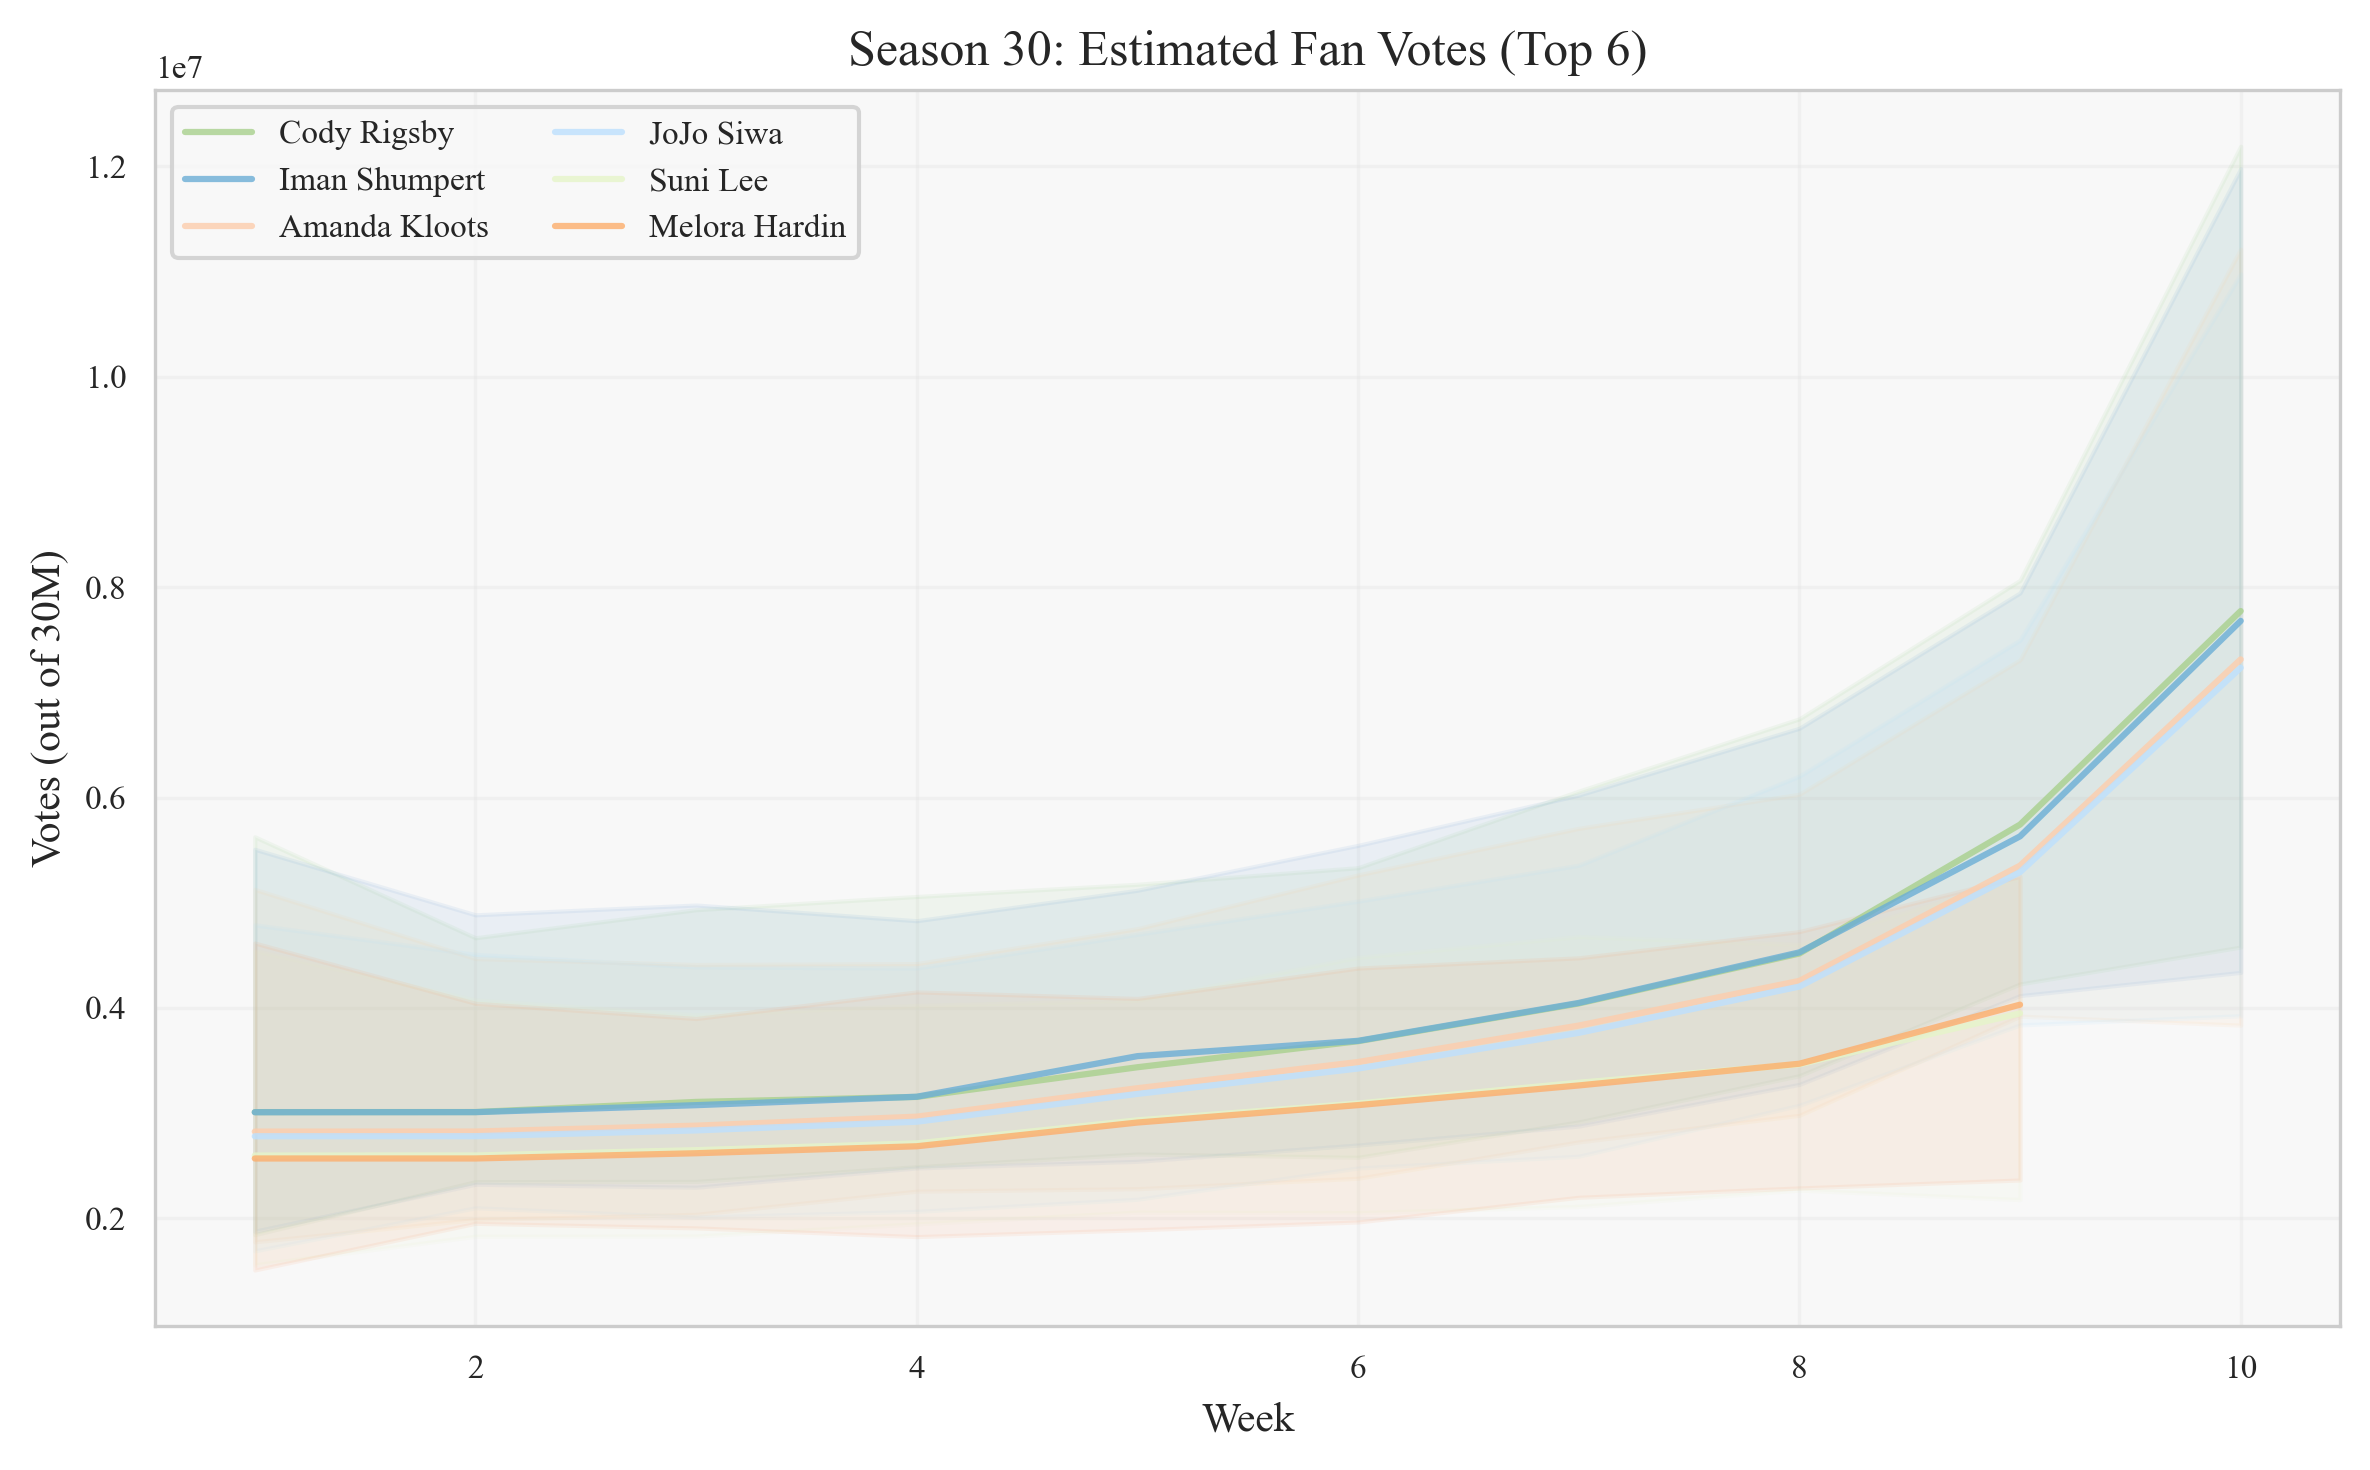

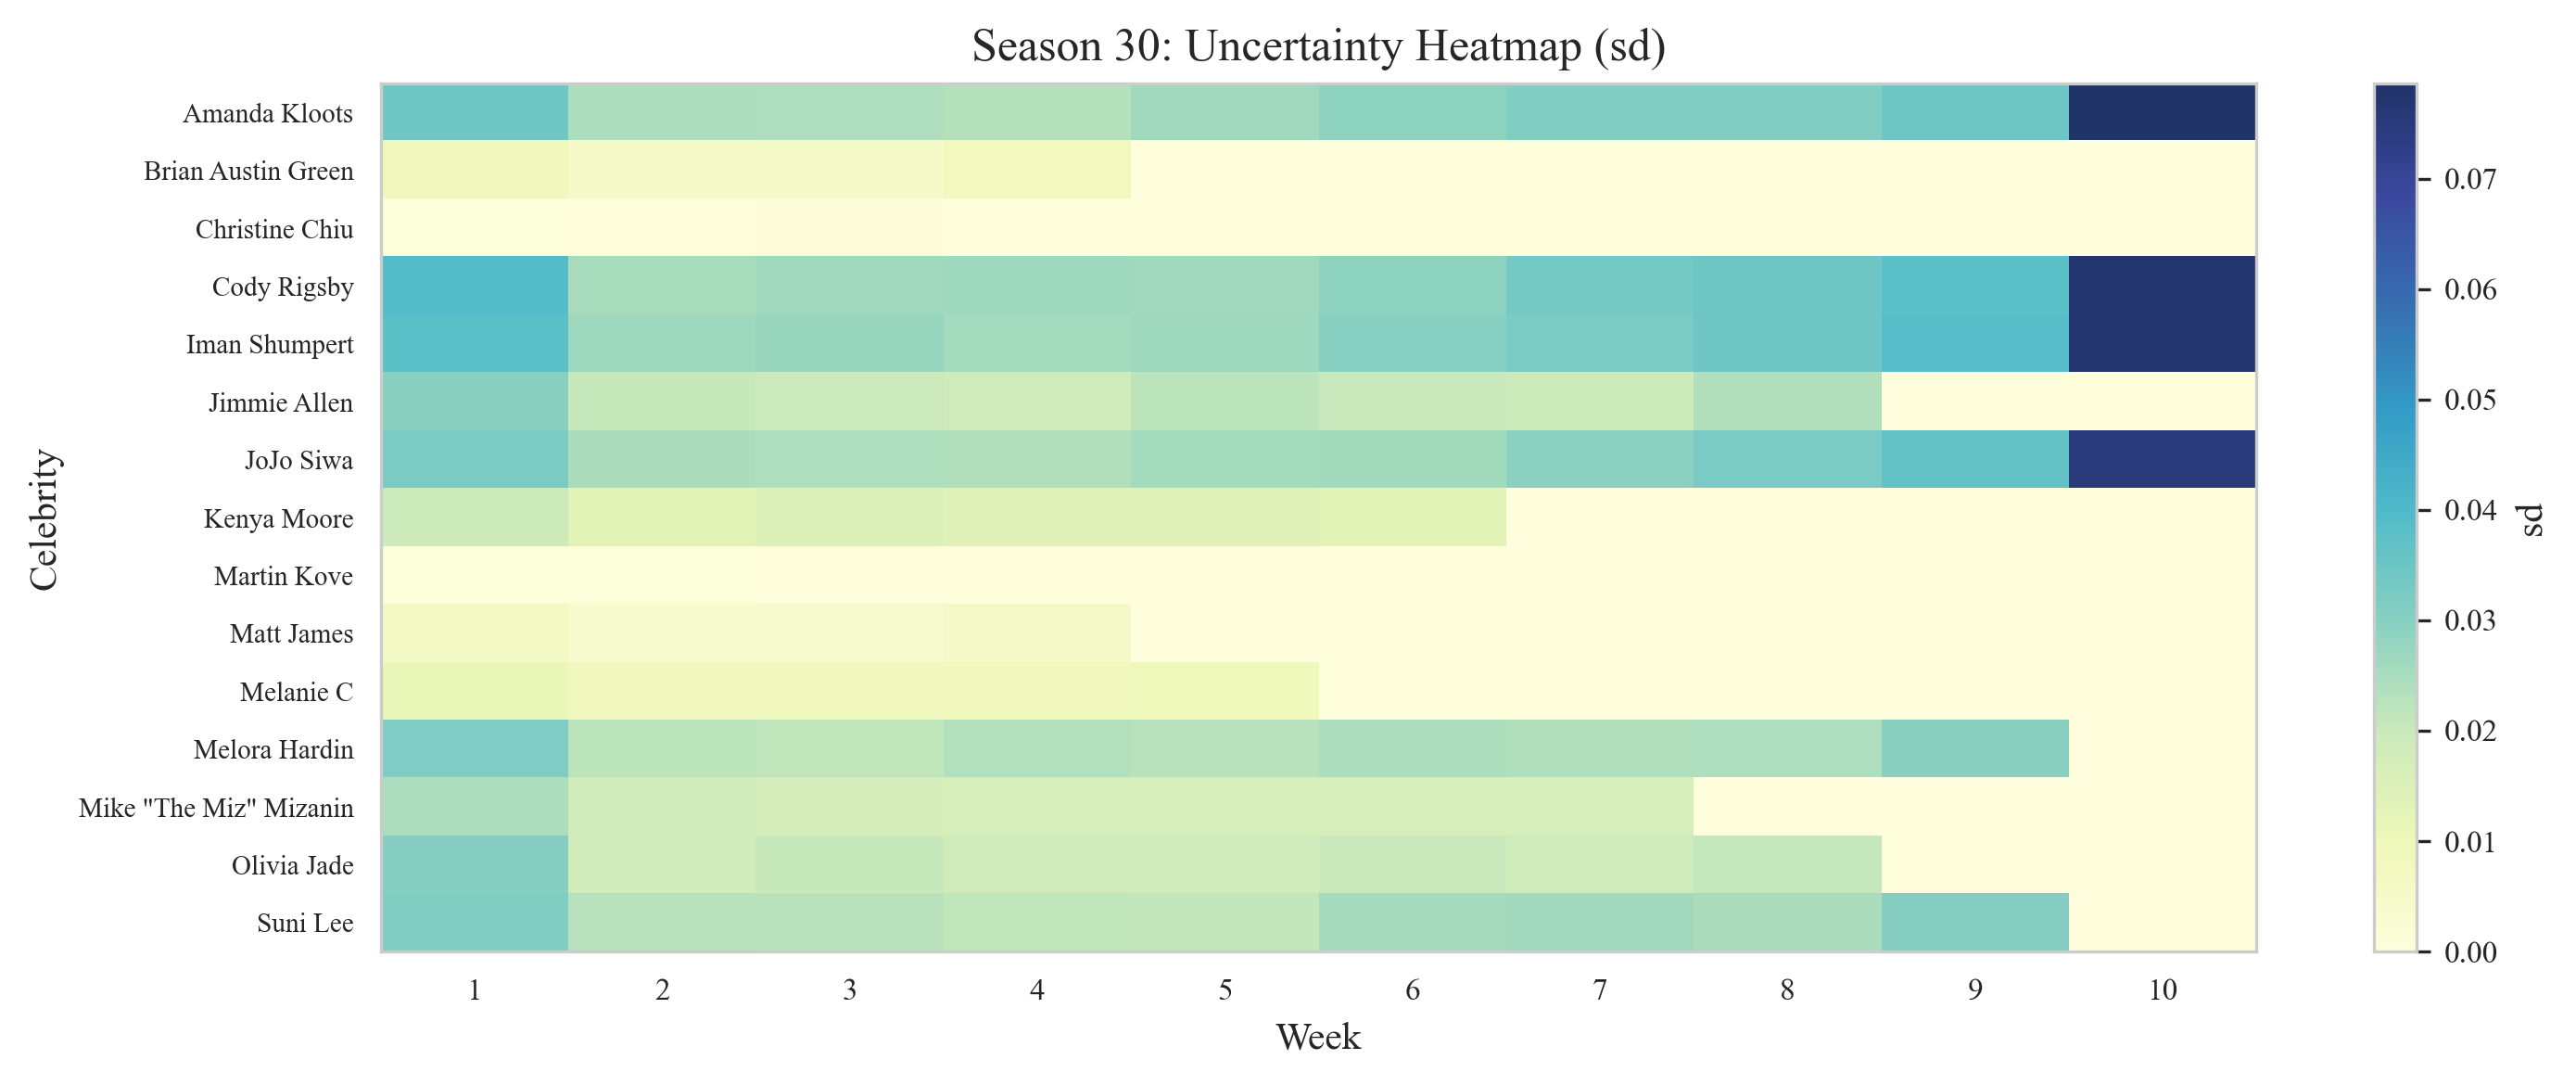

In [8]:
import re
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns  # 导入seaborn，用于更美观的学术风格

TOTAL_VOTES = 30_000_000  # 假设：每季每周总票数固定 3000 万


# -----------------------
# 0) 数据整理
# -----------------------
WEEK_JUDGE_RE = re.compile(r"week(\d+)_judge(\d+)_score")

def load_and_make_long(csv_path: str, max_season: int = 34) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df = df[df["season"] <= max_season].copy()

    week_cols = [c for c in df.columns if c.startswith("week") and c.endswith("_score")]
    long = df.melt(
        id_vars=[
            "celebrity_name", "ballroom_partner", "celebrity_industry",
            "celebrity_homestate", "celebrity_homecountry/region",
            "celebrity_age_during_season", "season", "results", "placement"
        ],
        value_vars=week_cols,
        var_name="wk_j", value_name="score"
    )
    long["week"] = long["wk_j"].str.extract(r"week(\d+)_").astype(int)
    long["judge"] = long["wk_j"].str.extract(r"_judge(\d+)_").astype(int)
    long["score"] = pd.to_numeric(long["score"], errors="coerce")
    long = long.drop(columns=["wk_j"])

    # 每位选手每周评委总分（忽略 NA）
    wk_tot = (
        long.groupby(["season", "celebrity_name", "week"], as_index=False)["score"]
        .sum(min_count=1)
        .rename(columns={"score": "judge_total"})
    )
    wk_tot["active"] = wk_tot["judge_total"].fillna(0.0) > 0.0  # 0 表示淘汰后不再参赛

    # 每周评委百分比（只在 active 的人里归一化）
    def add_judge_percent(g: pd.DataFrame) -> pd.DataFrame:
        active = g[g["active"]].copy()
        denom = active["judge_total"].sum()
        g["judge_percent"] = np.nan
        if denom > 0:
            g.loc[g["active"], "judge_percent"] = active["judge_total"] / denom
        return g

    wk_tot = wk_tot.groupby(["season", "week"], as_index=False, group_keys=False).apply(add_judge_percent)

    # 从 results 解析淘汰周
    def parse_elim_week(res: str) -> Optional[int]:
        m = re.match(r"Eliminated Week (\d+)", str(res))
        return int(m.group(1)) if m else None

    base = df[[
        "season", "celebrity_name", "results", "placement",
        "celebrity_industry", "celebrity_age_during_season"
    ]].copy()
    base["elim_week"] = base["results"].apply(parse_elim_week)
    base["withdrew"] = base["results"].eq("Withdrew")

    # 退赛周：该选手最后一个 active 的 week（退赛后也会变 0）
    last_active = (
        wk_tot[wk_tot["active"]]
        .groupby(["season", "celebrity_name"], as_index=False)["week"]
        .max()
        .rename(columns={"week": "last_week_active"})
    )
    base = base.merge(last_active, on=["season", "celebrity_name"], how="left")
    base["withdrew_week"] = np.where(base["withdrew"], base["last_week_active"], np.nan)

    # 合并到周级别表
    wk = wk_tot.merge(base[["season", "celebrity_name", "elim_week", "withdrew_week"]], on=["season", "celebrity_name"], how="left")

    # 每季最大有效周（当周至少有人 active）
    season_max_week = wk[wk["active"]].groupby("season")["week"].max().to_dict()
    wk["season_max_week"] = wk["season"].map(season_max_week)

    return wk


@dataclass
class WeekEvent:
    season: int
    week: int
    active_names: List[str]
    eliminated_names: List[str]      # Eliminated Week t
    withdrew_names: List[str]        # Withdrew at week t
    is_no_elim_week: bool            # 0 elim + 0 withdrew
    k_elim: int
    judge_percent: np.ndarray        # aligned with active_names


def build_week_events(wk: pd.DataFrame) -> Dict[Tuple[int, int], WeekEvent]:
    events = {}
    for (s, t), g in wk.groupby(["season", "week"]):
        season_max = g["season_max_week"].iloc[0]
        if pd.isna(season_max) or t > int(season_max):
            continue

        active_g = g[g["active"]].copy()
        active_names = active_g["celebrity_name"].tolist()
        J = active_g["judge_percent"].to_numpy()

        eliminated = active_g[active_g["elim_week"].eq(t)]["celebrity_name"].tolist()
        withdrew = active_g[active_g["withdrew_week"].eq(t)]["celebrity_name"].tolist()

        # finals 周通常没有 "Eliminated Week t"，这里自然 k_elim=0
        k_elim = len(eliminated)
        is_no_elim = (k_elim == 0) and (len(withdrew) == 0)

        events[(s, t)] = WeekEvent(
            season=s, week=t, active_names=active_names,
            eliminated_names=eliminated, withdrew_names=withdrew,
            is_no_elim_week=is_no_elim, k_elim=k_elim, judge_percent=J
        )
    return events


# -----------------------
# 1) 模型A：最大熵 + 平滑 + 硬约束（SLSQP）
# -----------------------
def _soft_entropy(v: np.ndarray, eps: float = 1e-12) -> float:
    v = np.clip(v, eps, 1.0)
    return -np.sum(v * np.log(v))

def estimate_votes_modelA(events: Dict[Tuple[int, int], WeekEvent],
                          season: int,
                          smooth_lambda: float = 10.0,
                          entropy_lambda: float = 1.0,
                          eps: float = 1e-6) -> pd.DataFrame:
    # 返回: season, week, celebrity_name, vote_share_A, votes_A
    season_events = [ev for (s, _), ev in events.items() if s == season]
    season_events = sorted(season_events, key=lambda e: e.week)

    out_rows = []
    v_prev = None

    for ev in season_events:
        names = ev.active_names
        n = len(names)
        J = ev.judge_percent.copy()

        # 初值：均匀或沿用上一周
        if v_prev is None or len(v_prev) != n:
            x0 = np.ones(n) / n
        else:
            x0 = v_prev.copy()

        # 目标：最小化 = 平滑惩罚 - 熵（等价最大熵） + 小的L2避免数值问题
        def obj(v):
            v = np.clip(v, eps, 1.0)
            v = v / v.sum()
            smooth = 0.0
            if v_prev is not None and len(v_prev) == n:
                smooth = np.sum((v - v_prev) ** 2)
            return smooth_lambda * smooth - entropy_lambda * _soft_entropy(v) + 1e-4 * np.sum(v**2)

        # 约束：sum=1
        cons = [{"type": "eq", "fun": lambda v: np.sum(v) - 1.0}]

        # 约束：v_i >= eps
        bounds = [(eps, 1.0) for _ in range(n)]

        # 淘汰周硬约束（百分比合并口径）：J_e + v_e <= J_s + v_s
        elim_set = set(ev.eliminated_names)
        if len(elim_set) > 0:
            idx = {name: i for i, name in enumerate(names)}
            elim_idx = [idx[x] for x in ev.eliminated_names if x in idx]
            surv_idx = [i for i, nm in enumerate(names) if nm not in elim_set]
            # 多淘汰：要求每个淘汰者都不优于任何未淘汰者
            for ei in elim_idx:
                for si in surv_idx:
                    cons.append({"type": "ineq", "fun": lambda v, ei=ei, si=si: (J[si] + v[si]) - (J[ei] + v[ei])})

        res = minimize(obj, x0, method="SLSQP", bounds=bounds, constraints=cons, options={"maxiter": 300})
        v_hat = res.x
        v_hat = np.clip(v_hat, eps, 1.0)
        v_hat = v_hat / v_hat.sum()

        v_prev = v_hat.copy()

        for nm, vs in zip(names, v_hat):
            out_rows.append({
                "season": season, "week": ev.week, "celebrity_name": nm,
                "vote_share_A": vs, "votes_A": vs * TOTAL_VOTES,
                "opt_success_A": bool(res.success)
            })

    return pd.DataFrame(out_rows)


# -----------------------
# 2) 模型B：贝叶斯思想（MAP + 拉普拉斯近似抽样）
# -----------------------
def sigmoid(x): return 1.0 / (1.0 + np.exp(-x))

def estimate_votes_modelB_map(events: Dict[Tuple[int, int], WeekEvent],
                              season: int,
                              sigma_rw: float = 0.35,
                              kappa: float = 40.0,
                              l2_beta: float = 1.0,
                              n_samples: int = 500,
                              seed: int = 7) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    输出：
    - df_map: season, week, celebrity_name, vote_share_B, votes_B
    - df_samples: season, week, celebrity_name, sample_id, vote_share_sample
    说明：用随机游走高斯先验 + logistic(软约束)似然，求MAP；再用拉普拉斯近似采样。
    """
    rng = np.random.default_rng(seed)
    season_events = [ev for (s, _), ev in events.items() if s == season]
    season_events = sorted(season_events, key=lambda e: e.week)

    # 构建参数索引：每个(week, name)一个 u
    keys = []
    for ev in season_events:
        for nm in ev.active_names:
            keys.append((ev.week, nm))
    keys = list(dict.fromkeys(keys))  # 去重保持顺序
    K = len(keys)
    key_to_i = {k: i for i, k in enumerate(keys)}

    # 帮助：给定 u，取某周的 v=softmax(u_week)
    def week_softmax(u_vec: np.ndarray, ev: WeekEvent) -> np.ndarray:
        idx = [key_to_i[(ev.week, nm)] for nm in ev.active_names]
        z = u_vec[idx]
        z = z - np.max(z)
        e = np.exp(z)
        return e / e.sum()

    # 负对数后验：= 软约束logistic损失 + RW先验
    def nlp(u_vec: np.ndarray) -> float:
        val = 0.0

        # RW先验：同一选手跨周差分（仅在相邻周都 active 时）
        # 这里用“名字匹配”做简单RW（足够写进MCM）
        by_name = {}
        for (w, nm), ii in key_to_i.items():
            by_name.setdefault(nm, []).append((w, ii))
        for nm, arr in by_name.items():
            arr = sorted(arr, key=lambda x: x[0])
            for (w1, i1), (w2, i2) in zip(arr[:-1], arr[1:]):
                if w2 == w1 + 1:
                    diff = u_vec[i2] - u_vec[i1]
                    val += 0.5 * (diff / sigma_rw) ** 2

        # 软淘汰似然：对每个(e,s)加 logistic loss
        for ev in season_events:
            if ev.k_elim <= 0:
                continue
            v = week_softmax(u_vec, ev)
            J = ev.judge_percent
            names = ev.active_names
            idx = {nm: i for i, nm in enumerate(names)}
            elim = [idx[x] for x in ev.eliminated_names if x in idx]
            elim_set = set(elim)
            surv = [i for i in range(len(names)) if i not in elim_set]
            for ei in elim:
                for si in surv:
                    # 希望 (J_s+v_s) - (J_e+v_e) 为正
                    d = (J[si] + v[si]) - (J[ei] + v[ei])
                    # -log sigmoid(kappa*d)
                    val += -np.log(sigmoid(kappa * d) + 1e-12)

        # 轻微L2，避免数值发散（可视为弱先验）
        val += 0.5 * l2_beta * np.sum(u_vec**2) / K
        return val

    # 用 L-BFGS-B 求 MAP（无约束）
    u0 = rng.normal(0, 0.1, size=K)
    res = minimize(nlp, u0, method="L-BFGS-B", options={"maxiter": 500})
    u_map = res.x

    # 拉普拉斯近似：用数值方式估对角Hessian（够用来做不确定性）
    # H_ii ≈ (f(x+h)-2f(x)+f(x-h))/h^2
    h = 1e-3
    f0 = nlp(u_map)
    Hdiag = np.zeros(K)
    for i in range(K):
        du = np.zeros(K); du[i] = h
        fp = nlp(u_map + du)
        fm = nlp(u_map - du)
        Hdiag[i] = max((fp - 2*f0 + fm) / (h*h), 1e-6)
    cov_diag = 1.0 / Hdiag  # 近似协方差对角

    # 抽样 u ~ N(u_map, diag(cov))
    U = rng.normal(u_map, np.sqrt(cov_diag), size=(n_samples, K))

    # 生成样本的 vote share
    sample_rows = []
    map_rows = []

    for ev in season_events:
        v_map = week_softmax(u_map, ev)
        for nm, vs in zip(ev.active_names, v_map):
            map_rows.append({
                "season": season, "week": ev.week, "celebrity_name": nm,
                "vote_share_B": vs, "votes_B": vs * TOTAL_VOTES,
                "opt_success_B": bool(res.success)
            })

        # samples
        for sid in range(n_samples):
            v_s = week_softmax(U[sid], ev)
            for nm, vs in zip(ev.active_names, v_s):
                sample_rows.append({
                    "season": season, "week": ev.week, "celebrity_name": nm,
                    "sample_id": sid, "vote_share_sample": vs
                })

    return pd.DataFrame(map_rows), pd.DataFrame(sample_rows)


# -----------------------
# 3) 集成 + 指标
# -----------------------
def ensemble_votes(dfA: pd.DataFrame, dfB: pd.DataFrame, weight_B: float = 0.6) -> pd.DataFrame:
    df = dfA.merge(dfB, on=["season", "week", "celebrity_name"], how="inner")
    df["vote_share_ens"] = weight_B * df["vote_share_B"] + (1 - weight_B) * df["vote_share_A"]
    df["votes_ens"] = df["vote_share_ens"] * TOTAL_VOTES
    return df

def evaluate_elim_hit_rate(events: Dict[Tuple[int, int], WeekEvent],
                           votes_df: pd.DataFrame,
                           share_col: str = "vote_share_ens") -> pd.DataFrame:
    """
    返回每季：淘汰一致性（多人淘汰：是否落在最低k）
    """
    rows = []
    for season in sorted(votes_df["season"].unique()):
        season_events = [ev for (s, _), ev in events.items() if s == season]
        season_events = sorted(season_events, key=lambda e: e.week)

        hits = 0
        denom = 0
        margins = []

        for ev in season_events:
            if ev.k_elim <= 0:
                continue
            denom += 1
            sub = votes_df[(votes_df["season"] == season) & (votes_df["week"] == ev.week)]
            sub = sub.set_index("celebrity_name")

            # 合并分（按percent口径）：J + v
            # （即便 season 1-2 是 rank，这里也可当“统一口径的 consistency”）
            combined = []
            for nm, J in zip(ev.active_names, ev.judge_percent):
                v = float(sub.loc[nm, share_col]) if nm in sub.index else 0.0
                combined.append((nm, J + v))
            combined_sorted = sorted(combined, key=lambda x: x[1])  # 越小越差

            k = ev.k_elim
            predicted_bottom_k = {nm for nm, _ in combined_sorted[:k]}
            actual_elim = set(ev.eliminated_names)

            hit = actual_elim.issubset(predicted_bottom_k)
            hits += int(hit)

            # margin：淘汰阈值与紧邻者差（k=1时就是倒数第二-倒数第一）
            if len(combined_sorted) > k:
                thr = combined_sorted[k-1][1]
                nxt = combined_sorted[k][1]
                margins.append(nxt - thr)

        rows.append({
            "season": season,
            "elim_weeks": denom,
            "hit_rate": (hits / denom) if denom > 0 else np.nan,
            "avg_margin": float(np.mean(margins)) if margins else np.nan
        })
    return pd.DataFrame(rows)


# -----------------------
# 4) 不确定性：从 modelB samples 直接算区间；Z周会自然更宽
# -----------------------
def summarize_uncertainty(df_samples: pd.DataFrame) -> pd.DataFrame:
    g = df_samples.groupby(["season", "week", "celebrity_name"])["vote_share_sample"]
    out = g.agg(
        mean="mean",
        sd="std",
        p05=lambda x: np.quantile(x, 0.05),
        p95=lambda x: np.quantile(x, 0.95),
    ).reset_index()
    out["cv"] = out["sd"] / np.clip(out["mean"], 1e-12, None)
    out["votes_mean"] = out["mean"] * TOTAL_VOTES
    out["votes_p05"] = out["p05"] * TOTAL_VOTES
    out["votes_p95"] = out["p95"] * TOTAL_VOTES
    return out


# -----------------------
# 5) 可视化（核心优化：SCI学术风格 + 浅淡配色）
# -----------------------
# 全局设置：SCI学术风格初始化（运行一次即可）
def init_sci_plot_style():
    # 设置seaborn浅淡学术风格
    sns.set_style("whitegrid")  # 白色网格背景，简洁干净
    sns.set_palette("pastel")   # 浅淡低饱和配色，符合SCI要求（替代："muted" 更沉稳）
    
    # 自定义matplotlib参数，优化图表细节（删除无效的savefig.bbox_inches）
    plt.rcParams.update({
        "font.family": "serif",  # 衬线字体，学术图表标配（支持Latex更好）
        "font.serif": ["Times New Roman", "SimSun"],  # 英文+中文衬线字体
        "axes.labelsize": 10,     # 坐标轴标签大小
        "axes.titlesize": 12,     # 图表标题大小
        "xtick.labelsize": 8,     # x轴刻度大小
        "ytick.labelsize": 8,     # y轴刻度大小
        "legend.fontsize": 8,     # 图例大小
        "figure.dpi": 300,        # 高分辨率，避免模糊
        "savefig.dpi": 300,       # 保存图片高分辨率
        # 删掉这一行："savefig.bbox_inches": "tight",
        "axes.facecolor": "#f8f8f8",  # 坐标轴背景浅灰，更柔和（比纯白不刺眼）
        "grid.color": "#e0e0e0"   # 网格线浅灰，不抢主体数据风头
    })
# 初始化SCI风格（必须在可视化前调用）
init_sci_plot_style()

# 定义浅淡配色列表（备用，当自动配色不够时使用）
SCI_PASTEL_COLORS = [
    "#a8d08d",  # 浅绿
    "#6baed6",  # 浅蓝
    "#fdcdac",  # 浅橙
    "#bde0fe",  # 浅青
    "#e6f5c9",  # 浅黄绿
    "#fdae6b"   # 浅黄橙
]

def plot_season_topk(votes_df: pd.DataFrame,
                     unc_df: Optional[pd.DataFrame],
                     season: int,
                     k: int = 6,
                     share_col: str = "vote_share_ens"):
    df = votes_df[votes_df["season"] == season].copy()
    # 选整体平均份额最高的k人画线
    top = (
        df.groupby("celebrity_name")[share_col]
        .mean()
        .sort_values(ascending=False)
        .head(k)
        .index.tolist()
    )
    
    plt.figure(figsize=(8, 5))  # 合理的图表尺寸，适配学术论文
    for idx, nm in enumerate(top):
        sub = df[df["celebrity_name"] == nm].sort_values("week")
        # 使用浅淡配色，循环取用
        color = SCI_PASTEL_COLORS[idx % len(SCI_PASTEL_COLORS)]
        # 绘制线条：浅淡颜色，适当线宽，清晰可见
        plt.plot(sub["week"], sub[share_col] * TOTAL_VOTES, 
                 label=nm, color=color, linewidth=1.5, alpha=0.8)
        
        # 不确定性带（优化：更浅的填充色，更低透明度，不干扰主体）
        if unc_df is not None:
            u = unc_df[(unc_df["season"] == season) & (unc_df["celebrity_name"] == nm)].sort_values("week")
            if len(u) == len(sub):
                # 填充色比线条色更深一点，透明度降低，符合SCI严谨性
                fill_color = color.replace("#", "#").replace("a", "9").replace("b", "a")
                plt.fill_between(u["week"], u["votes_p05"], u["votes_p95"], 
                                 alpha=0.1, color=fill_color)  # 透明度0.1，不刺眼

    # 图表标签优化：简洁明了，符合学术规范
    plt.title(f"Season {season}: Estimated Fan Votes (Top {k})")
    plt.xlabel("Week")
    plt.ylabel("Votes (out of 30M)")
    plt.legend(ncol=2, frameon=True, fancybox=True, shadow=False)  # 图例简洁，无阴影
    plt.grid(True, alpha=0.3)  # 网格线低透明度，辅助阅读不干扰
    plt.tight_layout()
    plt.show()

def plot_uncertainty_heatmap(unc_df: pd.DataFrame, season: int, value_col: str = "sd"):
    df = unc_df[unc_df["season"] == season].copy()
    pivot = df.pivot_table(index="celebrity_name", columns="week", values=value_col, aggfunc="mean")
    pivot = pivot.fillna(0.0)
    
    plt.figure(figsize=(10, max(4, 0.25 * len(pivot))))
    # 热图配色优化：使用浅淡的发散色/顺序色，符合SCI要求（避免鲜艳彩虹色）
    # cmap选择：YlGnBu（浅黄绿到浅蓝）、Blues（浅蓝到深蓝），均为浅淡风格
    im = plt.imshow(pivot.values, aspect="auto", cmap="YlGnBu", alpha=0.9)
    
    # 颜色条优化：标签清晰，样式简洁
    cbar = plt.colorbar(im, label=value_col)
    cbar.ax.tick_params(labelsize=8)
    
    # 刻度优化
    plt.yticks(range(len(pivot.index)), pivot.index, fontsize=7)
    plt.xticks(range(len(pivot.columns)), pivot.columns, fontsize=8)
    plt.title(f"Season {season}: Uncertainty Heatmap ({value_col})")
    plt.xlabel("Week")
    plt.ylabel("Celebrity")
    plt.grid(False)  # 热图不需要网格线，保持整洁
    plt.tight_layout()
    plt.show()


# -----------------------
# 6) 主程序示例
# -----------------------
if __name__ == "__main__":
    csv_path = "2026_MCM_Problem_C_Data.csv"  # 改成你的路径
    wk = load_and_make_long(csv_path, max_season=34)
    events = build_week_events(wk)

    # 例：跑一个赛季（建议你们写报告时挑 2-3 个典型季展示）
    season = 30

    dfA = estimate_votes_modelA(events, season=season, smooth_lambda=15.0, entropy_lambda=1.0)
    dfB_map, dfB_samples = estimate_votes_modelB_map(events, season=season, sigma_rw=0.35, kappa=45.0, n_samples=400)

    dfEns = ensemble_votes(dfA, dfB_map, weight_B=0.7)

    # 一致性指标（该季）
    metrics = evaluate_elim_hit_rate(events, dfEns, share_col="vote_share_ens")
    print(metrics[metrics["season"] == season])

    # 不确定性汇总
    unc = summarize_uncertainty(dfB_samples)

    # 可视化（已应用SCI浅淡风格）
    plot_season_topk(dfEns, unc, season=season, k=6, share_col="vote_share_ens")
    plot_uncertainty_heatmap(unc, season=season, value_col="sd")

In [9]:

# -----------------------
# 5) 可视化（核心优化：SCI学术风格 + 浅淡配色）
# -----------------------
# 全局设置：SCI学术风格初始化（运行一次即可）
def init_sci_plot_style():
    # 设置seaborn浅淡学术风格
    sns.set_style("whitegrid")  # 白色网格背景，简洁干净
    sns.set_palette("pastel")   # 浅淡低饱和配色，符合SCI要求（替代："muted" 更沉稳）
    
    # 自定义matplotlib参数，优化图表细节（删除无效的savefig.bbox_inches）
    plt.rcParams.update({
        "font.family": "serif",  # 衬线字体，学术图表标配（支持Latex更好）
        "font.serif": ["Times New Roman", "SimSun"],  # 英文+中文衬线字体
        "axes.labelsize": 10,     # 坐标轴标签大小
        "axes.titlesize": 12,     # 图表标题大小
        "xtick.labelsize": 8,     # x轴刻度大小
        "ytick.labelsize": 8,     # y轴刻度大小
        "legend.fontsize": 8,     # 图例大小
        "figure.dpi": 300,        # 高分辨率，避免模糊
        "savefig.dpi": 300,       # 保存图片高分辨率
        # 删掉这一行："savefig.bbox_inches": "tight",
        "axes.facecolor": "#f8f8f8",  # 坐标轴背景浅灰，更柔和（比纯白不刺眼）
        "grid.color": "#e0e0e0"   # 网格线浅灰，不抢主体数据风头
    })
# 初始化SCI风格（必须在可视化前调用）
init_sci_plot_style()


# 定义浅淡配色列表（备用，当自动配色不够时使用）
SCI_PASTEL_COLORS = [
    "#a8d08d",  # 浅绿
    "#6baed6",  # 浅蓝
    "#fdcdac",  # 浅橙
    "#bde0fe",  # 浅青
    "#e6f5c9",  # 浅黄绿
    "#fdae6b"   # 浅黄橙
]

Data Loaded Successfully.

Processing Season 2 (RANK_STRICT)...
Season 2 Results:
  - Hit Rate: 85.71%
  - Avg Margin: 2.1429


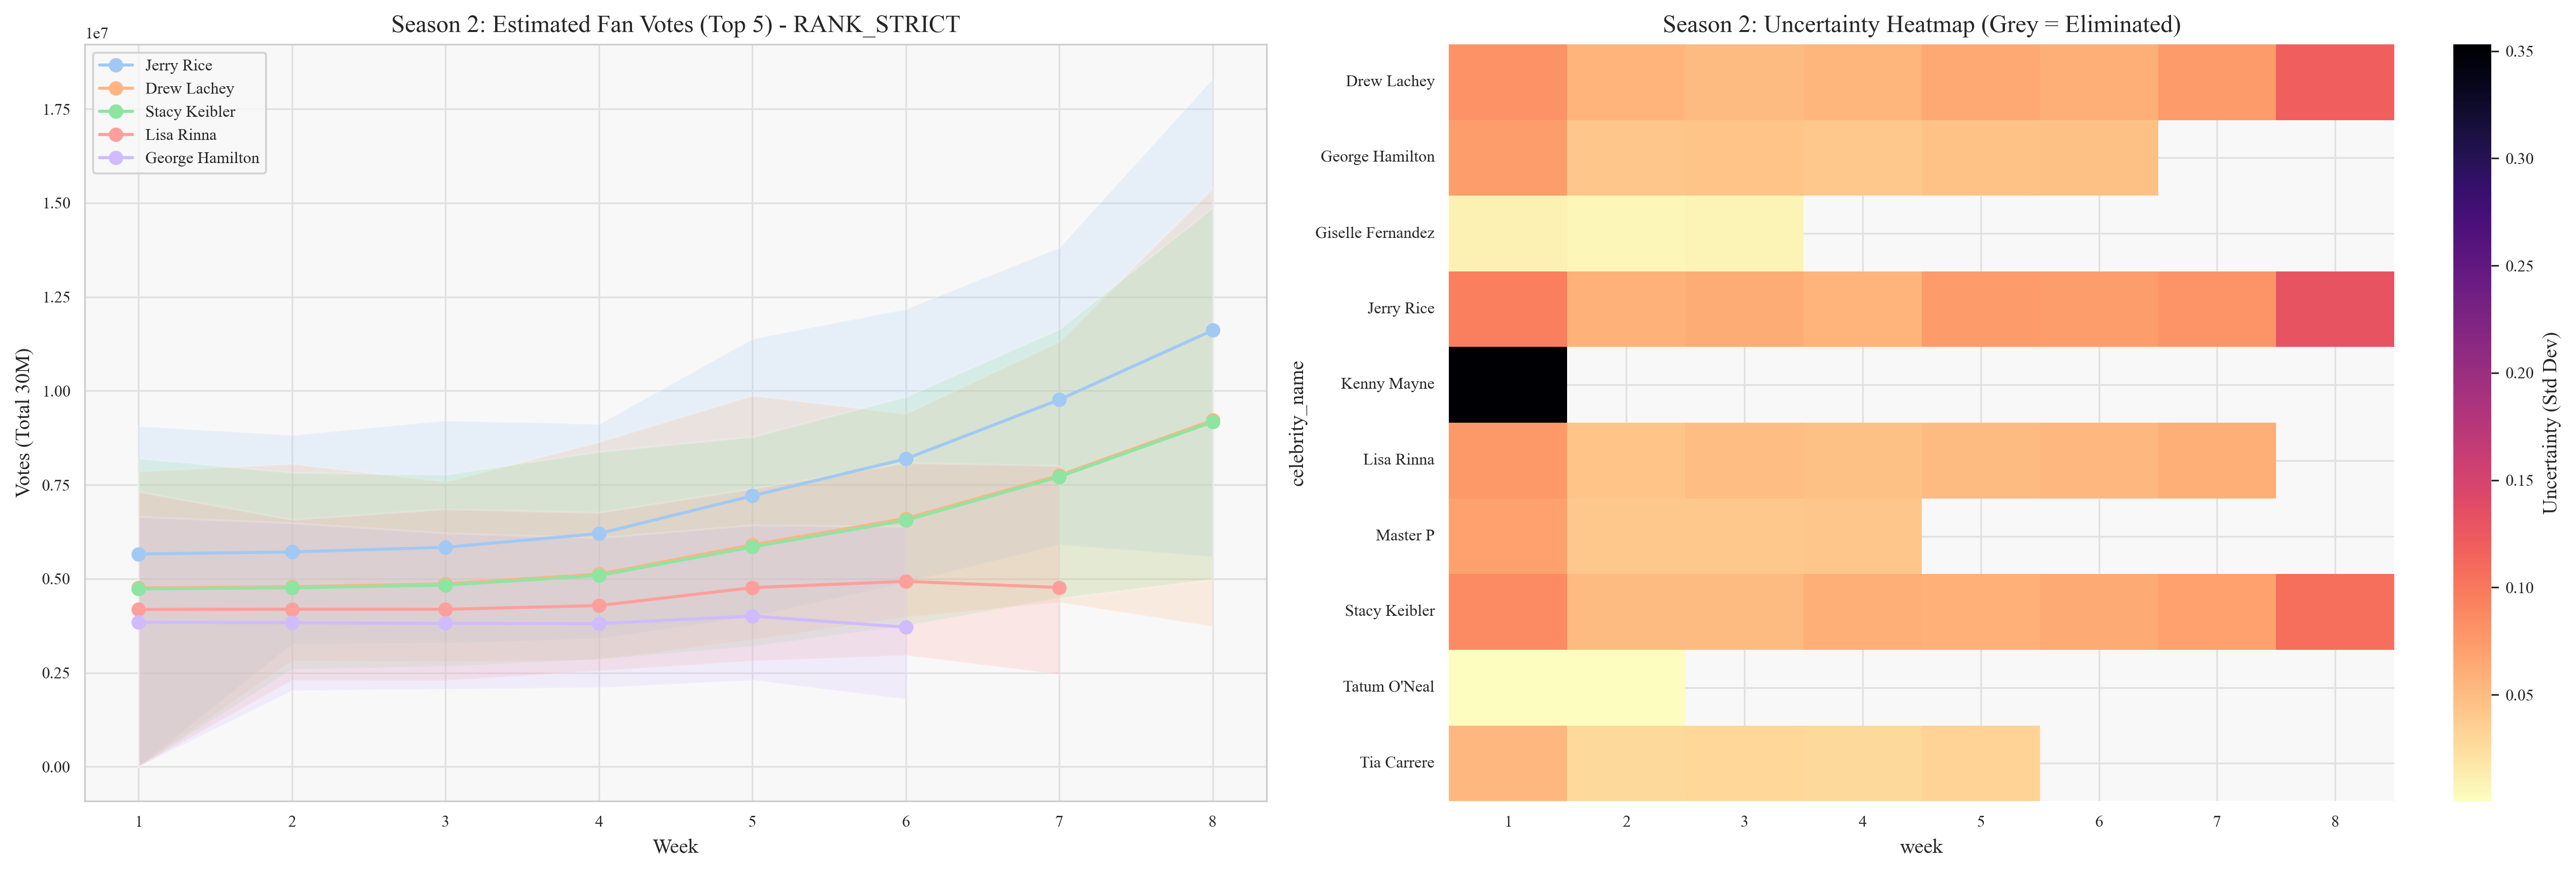


Processing Season 21 (PERCENT_STRICT)...
Season 21 Results:
  - Hit Rate: 100.00%
  - Avg Margin: 0.0496


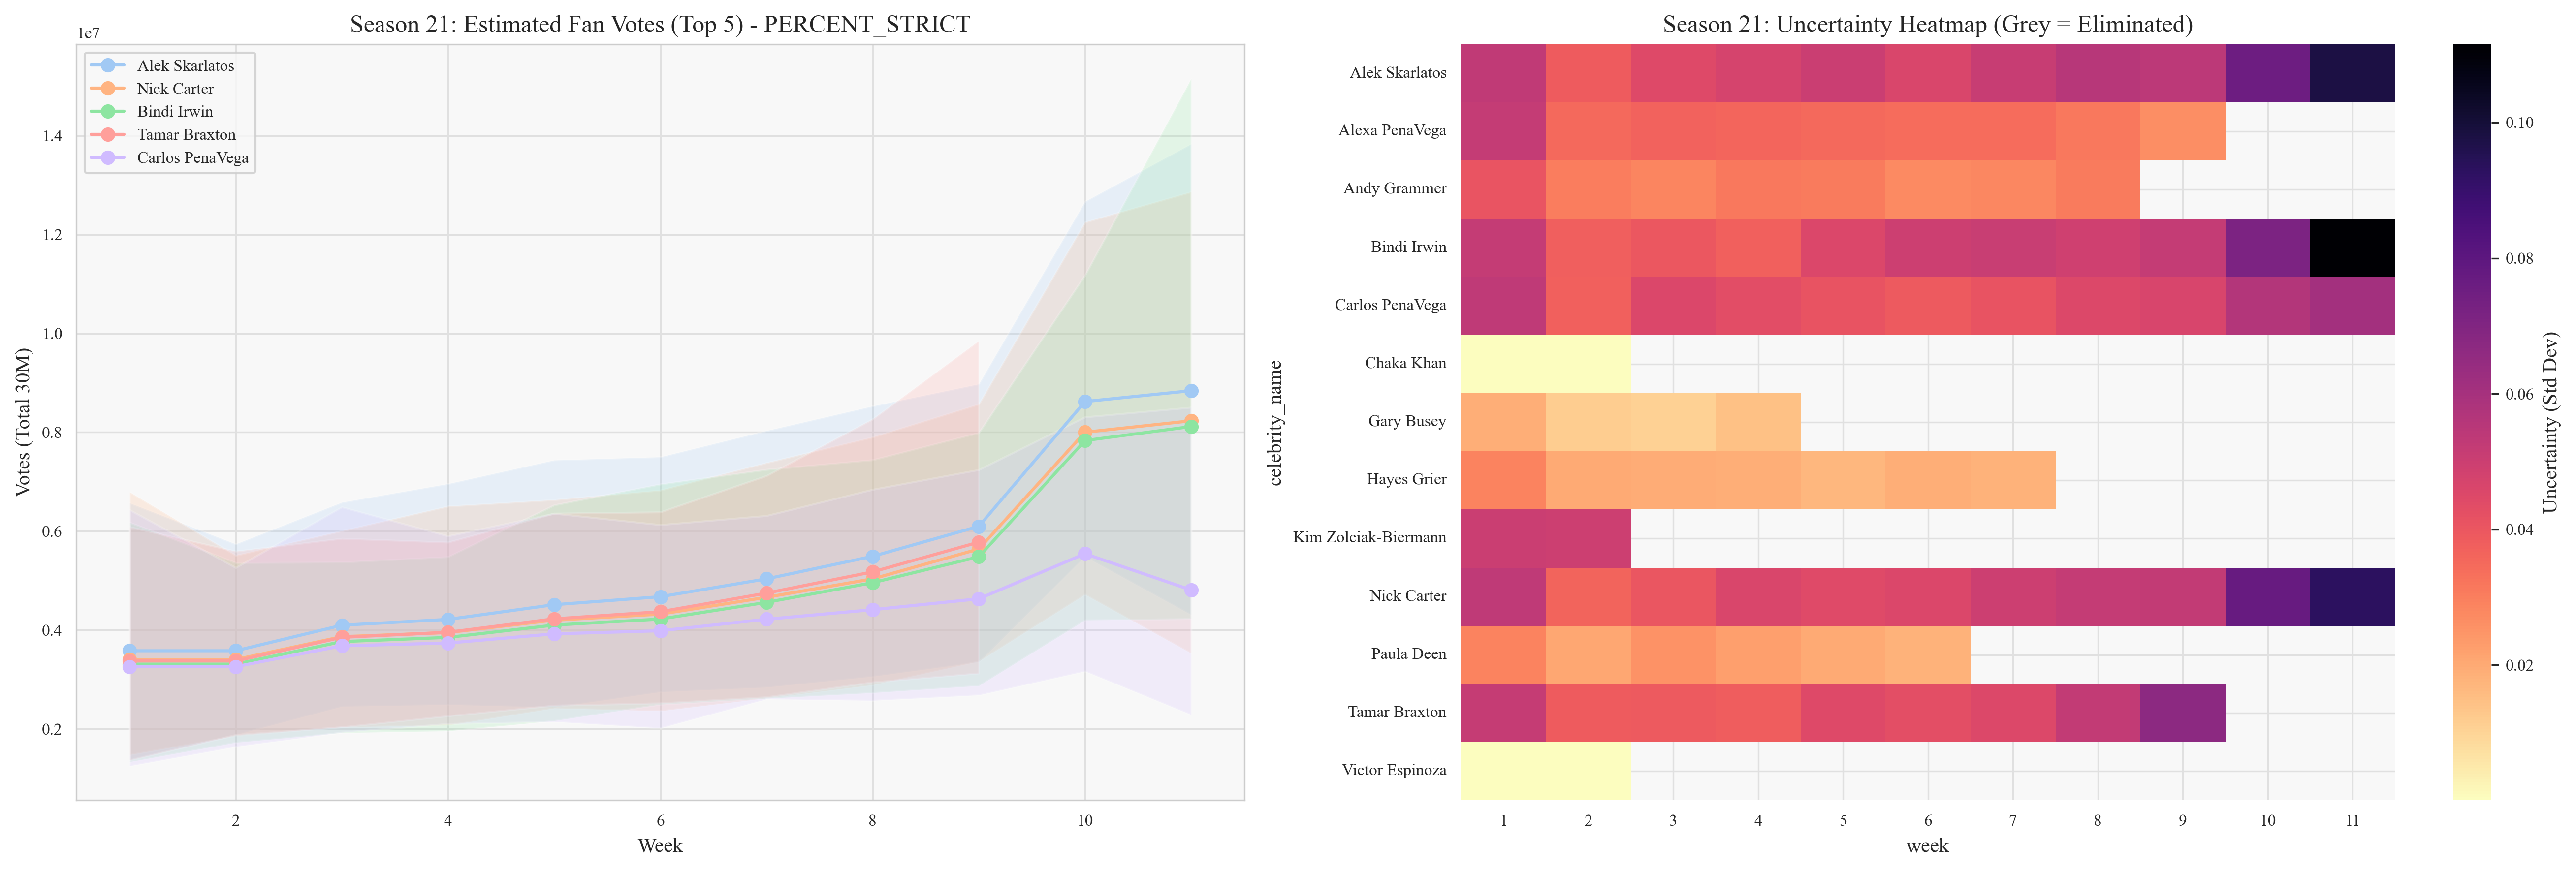


Processing Season 30 (RANK_BOTTOM2)...
Season 30 Results:
  - Hit Rate: 75.00%
  - Avg Margin: 1.7500


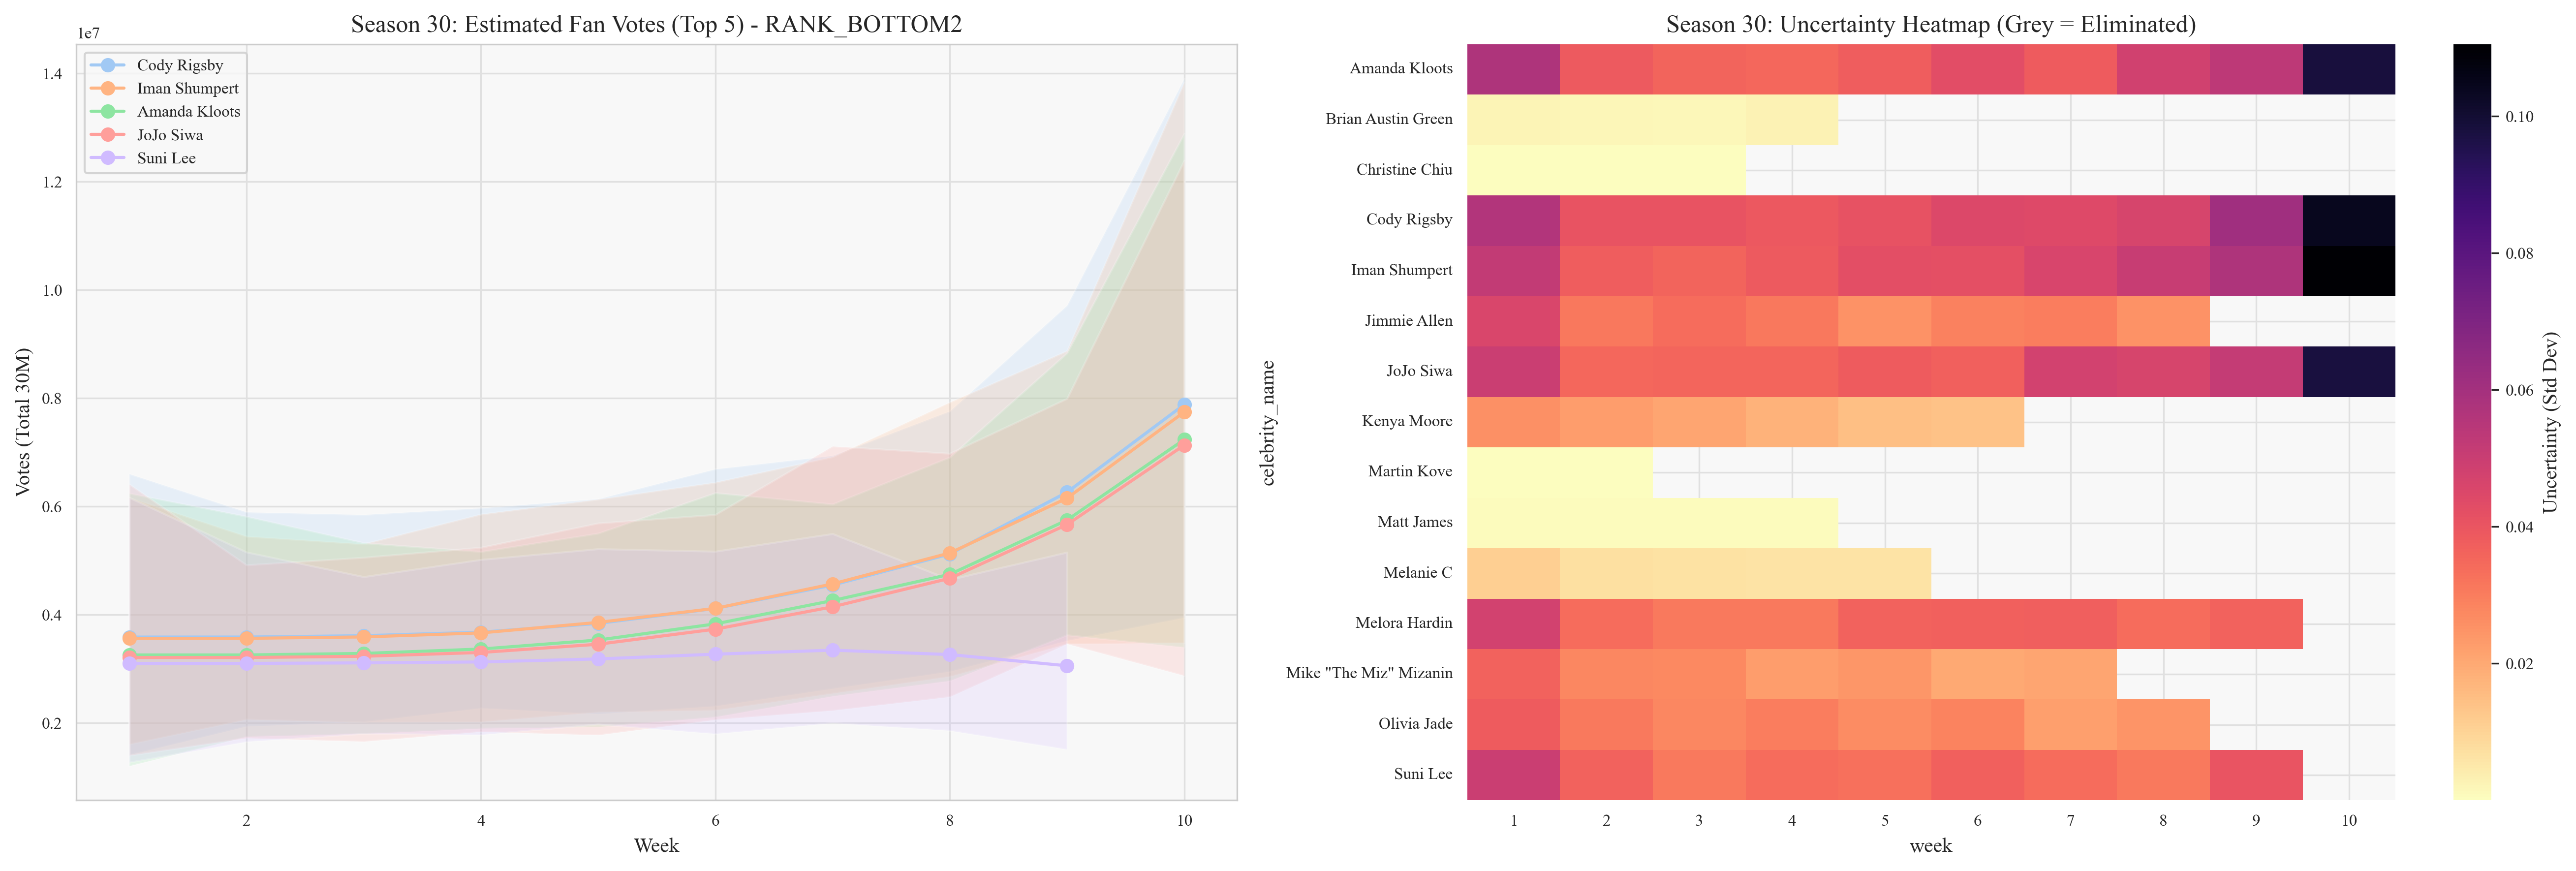

In [15]:
import re
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional

# 全局设定
TOTAL_VOTES = 30_000_000
np.random.seed(42)

# -------------------------------------------------------------------------
# 1. 核心工具函数：赛制判定与排名计算
# -------------------------------------------------------------------------

def get_season_rules(season: int) -> str:
    """根据赛季返回规则类型"""
    if season <= 2:
        return "RANK_STRICT"       # 排名制，最低分淘汰
    elif 3 <= season <= 27:
        return "PERCENT_STRICT"    # 百分比制，最低分淘汰
    else: # 28-34
        return "RANK_BOTTOM2"      # 排名制 -> 选出Bottom2 -> 评委二选一

def calculate_ranks(scores: np.array, ascending=False) -> np.array:
    """
    计算排名。
    DWTS规则：分数越高排名越靠前(1是最好)。
    ascending=False: 数值大 -> rank小(1)。
    """
    # method='min' 表示并列时取最小排名（即最好的名次），这是比赛常用逻辑，
    # 但为了求和方便，通常使用 'average' 或 'dense'。这里用 dense 保证连续性。
    # 注意：rankdata默认是升序(小数值rank 1)。
    if not ascending:
        return rankdata(-scores, method='min') 
    else:
        return rankdata(scores, method='min')

# -------------------------------------------------------------------------
# 2. 数据处理 (ETL)
# -------------------------------------------------------------------------

def load_and_process_data(csv_path: str) -> Tuple[pd.DataFrame, Dict]:
    df = pd.read_csv(csv_path)
    
    # 转长表
    week_cols = [c for c in df.columns if "week" in c and "judge" in c]
    long_df = df.melt(
        id_vars=["season", "celebrity_name", "results"],
        value_vars=week_cols,
        var_name="wk_str", value_name="score"
    )
    
    # 提取 Week 和 Judge 编号
    long_df["week"] = long_df["wk_str"].str.extract(r"week(\d+)_").astype(int)
    long_df["score"] = pd.to_numeric(long_df["score"], errors="coerce")
    
    # 聚合每周评委总分
    weekly = long_df.groupby(["season", "week", "celebrity_name", "results"])["score"].sum(min_count=1).reset_index()
    weekly.rename(columns={"score": "judge_points"}, inplace=True)
    
    # 标记 Active (分数 > 0)
    weekly["active"] = weekly["judge_points"].fillna(0) > 0
    weekly = weekly[weekly["active"]].copy()
    
    # 解析淘汰周
    def parse_elim(res):
        if isinstance(res, str) and "Eliminated Week" in res:
            return int(res.split("Week ")[1])
        return None
    weekly["elim_week"] = weekly["results"].apply(parse_elim)
    
    # 构建 Event 字典 (加速后续查表)
    # Key: (season, week) -> Value: Info Dict
    events = {}
    for (s, w), g in weekly.groupby(["season", "week"]):
        
        # 排除该季可能已经结束的后续空周
        if g.empty: continue
        
        rule = get_season_rules(s)
        names = g["celebrity_name"].values
        j_points = g["judge_points"].values
        
        # 1. 计算评委百分比 (S3-27用)
        j_percent = j_points / j_points.sum()
        
        # 2. 计算评委排名 (S1-2, S28-34用) - 分数高(好) -> Rank 1(小)
        # 注意：后续合成时，Rank 1 + Rank 1 = 2 (最好)，Rank N + Rank N = 2N (最差)
        # 淘汰机制是剔除 Sum 最大的。
        j_rank = calculate_ranks(j_points, ascending=False)
        
        # 识别淘汰者
        eliminated = g[g["elim_week"] == w]["celebrity_name"].tolist()
        
        events[(s, w)] = {
            "season": s,
            "week": w,
            "rule": rule,
            "names": names,
            "j_points": j_points,
            "j_percent": j_percent,
            "j_rank": j_rank,
            "eliminated": eliminated,
            "k_elim": len(eliminated)
        }
        
    return weekly, events

# -------------------------------------------------------------------------
# 3. 贝叶斯/优化模型 (Model B) - 修正了列名生成
# -------------------------------------------------------------------------

def estimate_votes_map(events, target_season, sigma_rw=0.5, kappa=30):
    """
    对指定赛季进行 MAP 估计。
    """
    # 筛选本赛季周次
    s_events = sorted([e for k, e in events.items() if k[0] == target_season], key=lambda x: x['week'])
    if not s_events: return None, None
    
    # 构建参数映射: (week, name) -> index
    param_keys = []
    for ev in s_events:
        for name in ev['names']:
            param_keys.append((ev['week'], name))
    
    # 去重并保持顺序 (处理同一个选手多周出现)
    unique_keys = list(dict.fromkeys(param_keys))
    key_to_idx = {k: i for i, k in enumerate(unique_keys)}
    n_params = len(unique_keys)
    
    # 辅助：获取某周某人的 logit index
    def get_indices(ev):
        return [key_to_idx[(ev['week'], n)] for n in ev['names']]

    # Softmax
    def softmax(logits):
        e = np.exp(logits - np.max(logits))
        return e / np.sum(e)

    # 目标函数：负对数后验
    def neg_log_posterior(params):
        loss = 0.0
        
        # 1. Prior: Random Walk (平滑项)
        # 找到同一选手相邻周的 idx
        player_indices = {}
        for (w, n), idx in key_to_idx.items():
            if n not in player_indices: player_indices[n] = []
            player_indices[n].append((w, idx))
            
        for n, eps in player_indices.items():
            eps.sort() # 按周排序
            for i in range(len(eps) - 1):
                w1, idx1 = eps[i]
                w2, idx2 = eps[i+1]
                if w2 == w1 + 1: # 只有连续周才做约束
                    diff = params[idx2] - params[idx1]
                    loss += 0.5 * (diff / sigma_rw) ** 2
        
        # 2. Likelihood: 淘汰一致性
        for ev in s_events:
            if ev['k_elim'] == 0: continue # 无淘汰周无信息
            
            idx_list = get_indices(ev)
            logits = params[idx_list]
            v_share = softmax(logits)
            
            # 找到淘汰者和幸存者的索引
            elim_indices = [i for i, n in enumerate(ev['names']) if n in ev['eliminated']]
            surv_indices = [i for i, n in enumerate(ev['names']) if n not in ev['eliminated']]
            
            if not elim_indices: continue
            
            J = ev['j_percent']
            
            for e_idx in elim_indices:
                strength_e = J[e_idx] + v_share[e_idx]
                for s_idx in surv_indices:
                    strength_s = J[s_idx] + v_share[s_idx]
                    
                    # 我们希望 strength_e < strength_s (E比S弱)
                    # Loss = -log(sigmoid(kappa * (strength_s - strength_e)))
                    diff = strength_s - strength_e
                    loss += -np.log(1 / (1 + np.exp(-kappa * diff)) + 1e-9)

        # L2 正则 (防止数值爆炸)
        loss += 1e-4 * np.sum(params**2)
        return loss

    # 运行优化
    x0 = np.random.normal(0, 0.1, n_params)
    res = minimize(neg_log_posterior, x0, method='L-BFGS-B', options={'maxiter': 500})
    
    # 拉普拉斯近似 (Hessian -> Covariance) 计算不确定性
    u_map = res.x
    h = 1e-3
    hess_diag = []
    base_loss = neg_log_posterior(u_map)
    for i in range(n_params):
        x_plus = u_map.copy(); x_plus[i] += h
        x_minus = u_map.copy(); x_minus[i] -= h
        l_plus = neg_log_posterior(x_plus)
        l_minus = neg_log_posterior(x_minus)
        d2 = (l_plus + l_minus - 2*base_loss) / (h**2)
        hess_diag.append(max(d2, 1e-2)) # 防止除0
    
    std_devs = 1.0 / np.sqrt(np.array(hess_diag))
    
    # 抽样生成区间
    n_samples = 200
    samples = np.random.normal(u_map, std_devs, (n_samples, n_params))
    
    # 整理结果
    results = []
    for ev in s_events:
        idx_list = get_indices(ev)
        
        # MAP Share
        v_map = softmax(u_map[idx_list])
        
        # Sampled Shares (for uncertainty)
        v_samples = []
        for i in range(n_samples):
            v_samples.append(softmax(samples[i][idx_list]))
        v_samples = np.array(v_samples)
        
        v_std = np.std(v_samples, axis=0)
        v_low = np.percentile(v_samples, 5, axis=0)
        v_high = np.percentile(v_samples, 95, axis=0)

        for i, name in enumerate(ev['names']):
            # [Fix] 这里增加了 votes_low 和 votes_high 的计算
            results.append({
                "season": target_season,
                "week": ev['week'],
                "celebrity_name": name,
                "vote_share": v_map[i],
                "vote_share_std": v_std[i],
                "vote_share_low": v_low[i],
                "vote_share_high": v_high[i],
                "votes": v_map[i] * TOTAL_VOTES,
                "votes_low": v_low[i] * TOTAL_VOTES,   # <--- 新增
                "votes_high": v_high[i] * TOTAL_VOTES, # <--- 新增
                "status": "Eliminated" if name in ev['eliminated'] else "Safe"
            })
            
    return pd.DataFrame(results), s_events

# -------------------------------------------------------------------------
# 4. 关键：按赛制评估一致性 (Logic Switch)
# -------------------------------------------------------------------------

def evaluate_consistency(df_res, events):
    """
    根据不同赛季规则，计算 Hit Rate 和 Margin。
    """
    metrics = []
    
    for (s, w), ev in events.items():
        if ev['k_elim'] == 0: continue
        
        # 获取该周预测数据
        sub = df_res[(df_res['season'] == s) & (df_res['week'] == w)]
        if sub.empty: continue
        
        # 对齐数据
        name_map = dict(zip(sub['celebrity_name'], sub['vote_share']))
        v_share = np.array([name_map.get(n, 0) for n in ev['names']])
        
        rule = ev['rule']
        eliminated_names = set(ev['eliminated'])
        
        is_hit = False
        margin = 0.0
        
        # === 逻辑分支 ===
        
        if rule == "RANK_STRICT" or rule == "RANK_BOTTOM2":
            # 1. 计算 Rank
            # Judge Rank 已在 events 里: ev['j_rank'] (1是最好)
            # Fan Rank: 份额越大 -> Rank越小(1)
            f_rank = calculate_ranks(v_share, ascending=False)
            
            # Combined Rank Sum (越小越好，越大越差)
            combined_score = ev['j_rank'] + f_rank
            
            # 排序 (分数从高到低 -> 表现从差到好)
            # 我们需要找 "Worst" candidates
            sorted_indices = np.argsort(-combined_score) # 降序排列，第0个是分数最大的(最差)
            sorted_names = ev['names'][sorted_indices]
            sorted_scores = combined_score[sorted_indices]
            
            if rule == "RANK_STRICT": # S1-2
                # 淘汰者必须是 Sum 最大 (Rank Sum 最高)
                pred_elim = set(sorted_names[:ev['k_elim']])
                is_hit = eliminated_names.issubset(pred_elim)
                
                if len(sorted_scores) > ev['k_elim']:
                    s_elim = sorted_scores[ev['k_elim']-1]
                    s_safe = sorted_scores[ev['k_elim']]
                    margin = s_elim - s_safe 
            
            elif rule == "RANK_BOTTOM2": # S28-34
                threshold_idx = ev['k_elim'] + 1 
                if threshold_idx > len(sorted_names): threshold_idx = len(sorted_names)
                
                pred_bottom_group = set(sorted_names[:threshold_idx])
                
                is_hit = eliminated_names.issubset(pred_bottom_group)
                
                if len(sorted_scores) > threshold_idx:
                    margin = sorted_scores[threshold_idx-1] - sorted_scores[threshold_idx]

        elif rule == "PERCENT_STRICT": # S3-27
            # Score = J% + V% (越小越差)
            combined_score = ev['j_percent'] + v_share
            
            sorted_indices = np.argsort(combined_score)
            sorted_names = ev['names'][sorted_indices]
            sorted_scores = combined_score[sorted_indices]
            
            pred_elim = set(sorted_names[:ev['k_elim']])
            is_hit = eliminated_names.issubset(pred_elim)
            
            if len(sorted_scores) > ev['k_elim']:
                s_elim = sorted_scores[ev['k_elim']-1]
                s_safe = sorted_scores[ev['k_elim']]
                margin = s_safe - s_elim
        
        metrics.append({
            "season": s,
            "week": w,
            "rule": rule,
            "hit": int(is_hit),
            "margin": margin
        })
        
    return pd.DataFrame(metrics)

# -------------------------------------------------------------------------
# 5. 可视化 (Heatmap 修复版)
# -------------------------------------------------------------------------

def plot_results(res_df, unc_df, season):
    season_df = res_df[res_df['season'] == season]
    if season_df.empty: return

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # 图1: 票数趋势 (带区间)
    # 选Top 5展示
    top_stars = season_df.groupby("celebrity_name")["votes"].mean().nlargest(5).index
    
    for star in top_stars:
        data = season_df[season_df['celebrity_name'] == star]
        # [Fix] 现在 data 里面已经有 votes_low 和 votes_high 了
        axes[0].plot(data['week'], data['votes'], marker='o', label=star)
        axes[0].fill_between(data['week'], data['votes_low'], data['votes_high'], alpha=0.2)
    
    axes[0].set_title(f"Season {season}: Estimated Fan Votes (Top 5) - {get_season_rules(season)}")
    axes[0].set_xlabel("Week")
    axes[0].set_ylabel("Votes (Total 30M)")
    axes[0].legend()
    
    # 图2: 不确定性 Heatmap (Masked NaN)
    # Pivot: Index=Name, Col=Week, Val=Std
    piv = season_df.pivot(index="celebrity_name", columns="week", values="vote_share_std")
    
    # Seaborn 自动处理 NaN
    sns.heatmap(piv, ax=axes[1], cmap="magma_r", annot=False, cbar_kws={'label': 'Uncertainty (Std Dev)'})
    
    axes[1].set_title(f"Season {season}: Uncertainty Heatmap (Grey = Eliminated)")
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------------
# 主程序
# -------------------------------------------------------------------------
if __name__ == "__main__":
    # 1. 加载数据 (替换为你的CSV路径)
    csv_file = "2026_MCM_Problem_C_Data.csv" 
    try:
        weekly_data, all_events = load_and_process_data(csv_file)
        print("Data Loaded Successfully.")
        
        all_results = []
        
        # 2. 跑三个典型赛季代表三个阶段
        # Case 1: Season 2 (Rank Strict)
        # Case 2: Season 21 (Percent Strict)
        # Case 3: Season 30 (Rank + Bottom 2)
        target_seasons = [2, 21, 30] 
        
        for s in target_seasons:
            print(f"\nProcessing Season {s} ({get_season_rules(s)})...")
            res_df, s_events = estimate_votes_map(all_events, target_season=s)
            
            if res_df is not None:
                all_results.append(res_df)
                
                # 评估
                metrics = evaluate_consistency(res_df, all_events)
                season_metrics = metrics[metrics['season'] == s]
                hit_rate = season_metrics['hit'].mean()
                avg_margin = season_metrics['margin'].mean()
                
                print(f"Season {s} Results:")
                print(f"  - Hit Rate: {hit_rate:.2%}")
                print(f"  - Avg Margin: {avg_margin:.4f}")
                
                # 绘图
                plot_results(res_df, None, s)
        
        # 合并所有结果
        if all_results:
            final_df = pd.concat(all_results)
            
    except FileNotFoundError:
        print("Error: CSV file not found. Please check the path.")
